In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [2]:
!wget 'https://www.dropbox.com/s/zx2ljfm4ad985ty/plants-dataset-small.zip?dl=1' -O plant-data-small.zip


--2019-09-18 16:39:26--  https://www.dropbox.com/s/zx2ljfm4ad985ty/plants-dataset-small.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zx2ljfm4ad985ty/plants-dataset-small.zip [following]
--2019-09-18 16:39:26--  https://www.dropbox.com/s/dl/zx2ljfm4ad985ty/plants-dataset-small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd778e1abfd52fc7014ece36f15.dl.dropboxusercontent.com/cd/0/get/AoyeWdQN1xwB3J-25PXIuE1uIpL52GzBYAhplcFuu7sCKoc-9HuZoy9iFXJQoT5g3C5jvLv8sBie54-eu_9EOGDoNoMzSx0afrzaANArmsqQc2_mIH9vPUTULXwhG-KFVoc/file?dl=1# [following]
--2019-09-18 16:39:26--  https://ucd778e1abfd52fc7014ece36f15.dl.dropboxusercontent.com/cd/0/get/AoyeWdQN1xwB3J-25PXIuE1uIpL52GzBYAhplcFuu7sCKoc-9HuZoy9iFXJQoT5g3C5jvLv8s

In [0]:
!unzip -q './plant-data-small.zip'

In [0]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
base_dir = './plants-dataset-small/train_imgs'

In [5]:
tf.__version__

'2.0.0-rc0'

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 1992 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


In [7]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 256, 256, 3), (64, 5))

In [8]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'background': 4}


In [9]:
!cat labels.txt

Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
background

In [10]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
#include_top = False allows us to have model minus the classification layers
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

/tensorflow-2.0.0-rc0/python3.6/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 2s 0us/step


In [0]:
#Classification head
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 6, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,592,709
Non-trainable params: 34,112
_________________________________________________________________


In [14]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 160


In [15]:
epochs = 10

history = model.fit_generator(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
32/32 [==============================] - 39s 1s/step - loss: 0.4697 - accuracy: 0.8835 - val_loss: 7.5167 - val_accuracy: 0.3293
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.0824 - accuracy: 0.9799 - val_loss: 4.6799 - val_accuracy: 0.5192
Epoch 3/10
32/32 [==============================] - 34s 1s/step - loss: 0.0890 - accuracy: 0.9744 - val_loss: 8.0318 - val_accuracy: 0.2182
Epoch 4/10
32/32 [==============================] - 34s 1s/step - loss: 0.0504 - accuracy: 0.9945 - val_loss: 4.2726 - val_accuracy: 0.6081
Epoch 5/10
32/32 [==============================] - 34s 1s/step - loss: 0.1028 - accuracy: 0.9754 - val_loss: 5.6753 - val_accuracy: 0.4828
Epoch 6/10
32/32 [==============================] - 34s 1s/step - loss: 0.0949 - accuracy: 0.9900 - val_loss: 5.9209 - val_accuracy: 0.5495
Epoch 7/10
32/32 [==============================] - 34s 1s/step - 

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

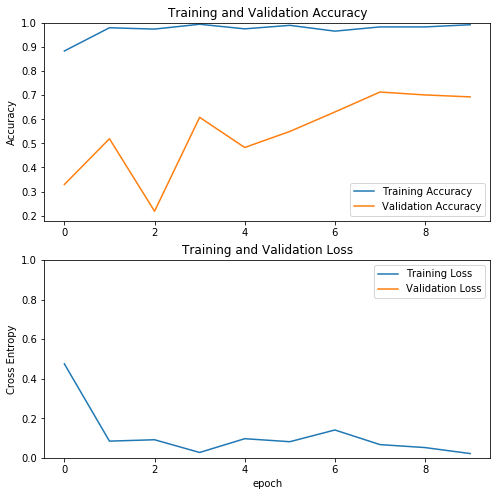

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
base_model.trainable = True

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 6, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [22]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [23]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

Epoch 1/5
32/32 [==============================] - 33s 1s/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 4.2279 - val_accuracy: 0.6990
Epoch 2/5
32/32 [==============================] - 32s 1s/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 4.0946 - val_accuracy: 0.7010
Epoch 3/5
32/32 [==============================] - 32s 997ms/step - loss: 0.0321 - accuracy: 0.9980 - val_loss: 4.0466 - val_accuracy: 0.6970
Epoch 4/5
32/32 [==============================] - 32s 998ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 3.9562 - val_accuracy: 0.6949
Epoch 5/5
32/32 [==============================] - 32s 996ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 3.8652 - val_accuracy: 0.6949


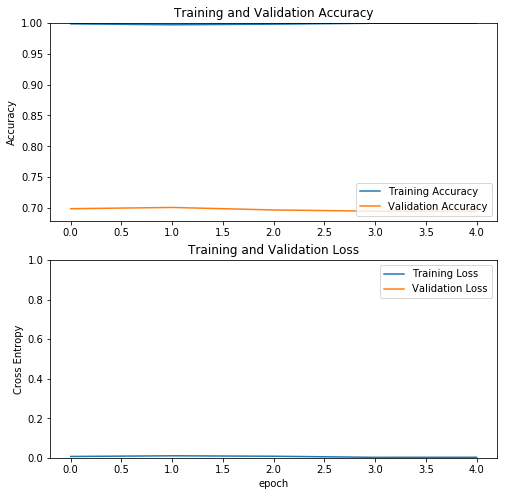

In [24]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [0]:
from google.colab import files

files.download('./model.tflite')
files.download('./labels.txt')

In [0]:
#Add code to load model and continue working on it here
#Add code to continue predictions here
